In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import glob
import os
import re
import pandas as pd
import tarfile
import P4J
from astropy.table import Table
from astropy.stats import sigma_clip
from metric_tools import *
from astroML.time_series import MultiTermFit
from astropy.stats import sigma_clip
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style="whitegrid", color_codes=True, context="poster")

mainpath = '/Users/jorgetil/Astro/HITS'

In [2]:
def multi_term_fit(time, mag, err, T, plot=False):
    mtf = MultiTermFit(2*np.pi/T, 4)
    mtf.fit(time, mag, err)
    phase_fit, y_fit, phased_t = mtf.predict(1000, return_phased_times=True)

    if plot:
        plt.figure(figsize=(9,4))
        plt.plot(phase_fit, y_fit, 'r-')
        plt.plot(phase_fit+1, y_fit, 'r-')
        plt.errorbar(phased_t, mag, yerr=err, fmt='k.', lw=1,alpha=1)
        plt.errorbar(phased_t+1, mag, yerr=err, fmt='k.', lw=1,alpha=1)
        plt.gca().invert_yaxis()
        plt.show()
    return

In [3]:
def HiTS_sample_func(time, mags_shape=1, cadence=0.067, n_points=30,
                     obs_per_night=5, delta=.002, plot=False):
    obs_idx = np.zeros(n_points, dtype='int')
    start_idx = np.random.randint(0, len(time)/10, size=mags_shape)[0]
    obs_idx[0] = start_idx
    start_time = time[start_idx]
    observs = 0
    while observs < n_points:
        if observs%obs_per_night != 0:
            next_time = start_time + cadence + np.random.normal(0, 0.003)
        else:
            next_time = start_time + .5 + np.random.normal(0, 0.003)
        idx = np.where((time > next_time - delta/2) & 
                       (time < next_time + delta/2))[0][0]
        obs_idx[observs] = idx
        start_time = time[idx]
        observs += 1
    if plot:
        plt.plot(time[obs_idx], '.')
        plt.show()
    return obs_idx

In [4]:
path = '%s/tables/Blind15A_kronPhot_only.csv' % (mainpath)
empirical = pd.read_csv(path)

In [5]:
empirical.head()

,gKronFlux,gKronFluxErr,gMedianKronMag,gMedianKronMagErr,gMedianKronMagStd,iKronFlux,iKronFluxErr,iMedianKronMag,iMedianKronMagErr,iMedianKronMagStd,internalID,rKronFlux,rKronFluxErr,rMedianKronMag,rMedianKronMagErr,rMedianKronMagStd
0,696810.75000,552.946594,15.300872,0.003753,0.267680,1159729.000,1430.097837,15.031651,0.007571,0.0,Blind15A_02_N1_1988_0086,1757073.000,924.670345,14.632674,0.008229,0.292597
1,430581.30000,446.147888,15.899939,0.003887,0.675814,565386.100,962.899452,15.811679,0.007678,0.0,Blind15A_02_N1_1184_0081,825026.900,1142.657004,15.476652,0.008593,0.465131
2,3697.47650,180.521063,20.990043,0.052813,0.073452,14352.010,491.811822,19.800260,0.037945,0.0,Blind15A_02_N1_1745_0068,10557.535,524.455346,20.147905,0.054081,0.068840
3,3909.96400,179.145940,20.945170,0.048629,0.075767,13683.460,537.032029,19.852052,0.043258,0.0,Blind15A_02_N1_1789_0059,9748.154,503.311713,20.213119,0.055952,0.037052
4,682.66345,74.587584,22.821135,0.118329,0.164192,8380.537,255.651374,20.384362,0.033949,0.0,Blind15A_02_N1_1587_0054,2879.782,170.338898,21.596249,0.064592,0.072596


In [6]:
table_file = '%s/tables/Blind15A_label_sample_new_PS.csv' % (mainpath)
table_15 = pd.read_csv(table_file)
table_15.set_index('internalID', inplace=True)

In [7]:
dsct = table_15.query('Var_Type == "DSCT"')
T = float(dsct['PeriodLS'])
T_W = float(dsct['PeriodWMCC'])
T_G = float(dsct['PeriodGLS'])
print dsct.index.values[0]
field, CCD, X, Y = re.findall(
            r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', dsct.index.values[0])[0]
time, mag, err, time2, mag2, err2 = give_me_lc(field, CCD, X, Y,extract=False)
filtered_data = sigma_clip(mag, sigma=3, iters=1,
                           cenfunc=np.mean, copy=False)
time = time[~filtered_data.mask]
mag = mag[~filtered_data.mask]
err = err[~filtered_data.mask]
print 'Period: %f days' % (T)

Blind15A_27_N4_1137_0808
Period: 0.060023 days


In [8]:
def GP_fit(time, mag, err, T, T_1=T, x_pred=None, plot=True):
    phase = np.mod(time, T) / T
    sort_idx = np.argsort(phase)
    PHASE = phase[sort_idx]
    MAG = mag[sort_idx]
    ERR = err[sort_idx]
    k=1
    while k < 2:
        MAG = np.concatenate([MAG,MAG])
        PHASE = np.concatenate([PHASE,PHASE+k])
        ERR = np.concatenate([ERR,ERR])
        k += 1
    #PHASE *= T
    kernel = C(constant_value=1., constant_value_bounds=(.1,.5)) * \
             RBF(length_scale=.3, length_scale_bounds=(0.2, .5))
    #kernel = C(constant_value=1., constant_value_bounds=(0.1,10.)) * \
    #         Matern(length_scale=4., length_scale_bounds=(.1,10.))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=(ERR)**2, optimizer='fmin_l_bfgs_b',
                                  n_restarts_optimizer=10, normalize_y=True)
    gp.fit(PHASE[:,None], MAG)
    x_test=np.linspace(0,2,1000)
    y_pred, sigma = gp.predict(x_test[:,None], return_std=True)
    
    phase_pred = np.mod(x_pred, T_1) / T_1
    mag_pred = gp.predict(phase_pred[:,None], return_std=False)
    
    if plot:
        plt.figure(figsize=(9,4))
        plt.errorbar(PHASE, MAG, yerr=ERR, fmt='k.', ms=7, lw=1,alpha=1)
        plt.plot(x_test, y_pred, 'r-', lw= 1)
        plt.fill(np.concatenate([x_test, x_test[::-1]]),
                 np.concatenate([y_pred - 1.9600 * sigma,
                                (y_pred + 1.9600 * sigma)[::-1]]),
                 alpha=.5, fc='b', ec='None')
        plt.plot(phase_pred, mag_pred, 'b.')
        plt.gca().invert_yaxis()
        plt.show()
        
    return mag_pred

In [9]:
css_path = '%s/CRTS/LCs/dsct_1.csv' % (mainpath)
css_dsct = pd.read_csv(css_path)
css_time = css_dsct.MJD.values
css_mag = css_dsct.Mag.values
css_err = css_dsct.Magerr.values
css_T = 0.0853060

In [10]:
def HiTS_depth_noise(mag):
    scale = np.random.choice(empirical.gMedianKronMag.values, size=1)
    btw = empirical.query('gMedianKronMag > %f-.05 and \
                       gMedianKronMag < %f+.05 and \
                       gMedianKronMagErr < .5' % (scale,scale))
    errors = np.random.choice(btw.gMedianKronMagErr,
                              size=len(mag)) / 2
    new_mag = scale*mag/mag.mean()
    #noise_mag = new_mag * np.random.normal(loc=1, scale=errors**2)
    noise_mag = np.zeros_like(new_mag)
    for k,m in enumerate(new_mag):
        rand = np.random.normal(loc=1, scale=errors[k]**2)
        noise_mag[k] = m * rand
        #print k,m, rand, noise_mag[k],errors[k]
    return new_mag, noise_mag, errors

In [103]:
time_all = []
for k in range(50):
    print '\r', k,
    if k == 2:continue
    path = '%s/INFO/times/Blind15A_%02i_epochs_g.txt' % (mainpath, int(k+1))
    aux = np.loadtxt(path)
    time_all.append(aux)

49


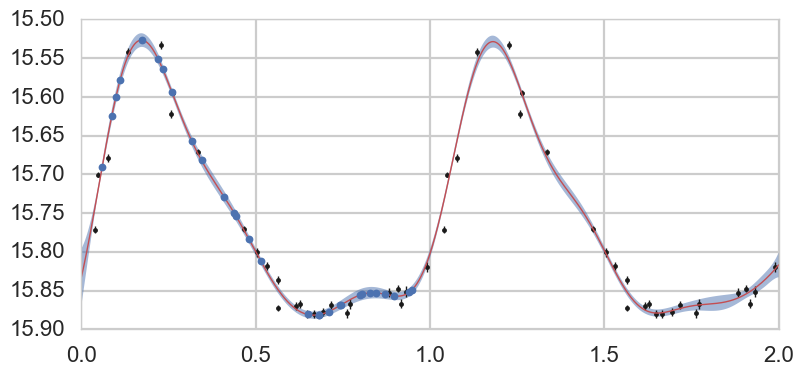

23.2696230382 22


In [118]:
# initial time range
time_obs = np.linspace(time.min(), time.min()+6., 100000)
# HiTS sampling function
# hits_time = time_obs[HiTS_sample_func(time_obs)]
n = np.random.choice(range(49))
hits_time = time_all[n][:,1]
# predicted magnitude for GP
mag_obs = GP_fit(time, mag, err, T, T_1=T, plot=True, x_pred=hits_time)
# scale to HiTS depth and add empirical uncertainties
hits_mag, hits_noise_mag, hits_err = HiTS_depth_noise(mag_obs)
if hits_mag.mean() < 20:
    size = int(len(hits_time)*np.random.uniform(.95,1., size=1))
elif hits_mag.mean() < 22 and hits_mag.mean() > 20:
    size = int(len(hits_time)*np.random.uniform(.8,1., size=1))
else:
    size = int(len(hits_time)*np.random.uniform(.65,1., size=1))  
print hits_mag.mean(), size
idx = np.sort(np.random.choice(np.arange(len(hits_time)),
                       size=size, replace=False))
hits_time = hits_time[idx]
hits_mag = hits_mag[idx]
hits_noise_mag = hits_noise_mag[idx]
hits_err = hits_err[idx]

(21,)


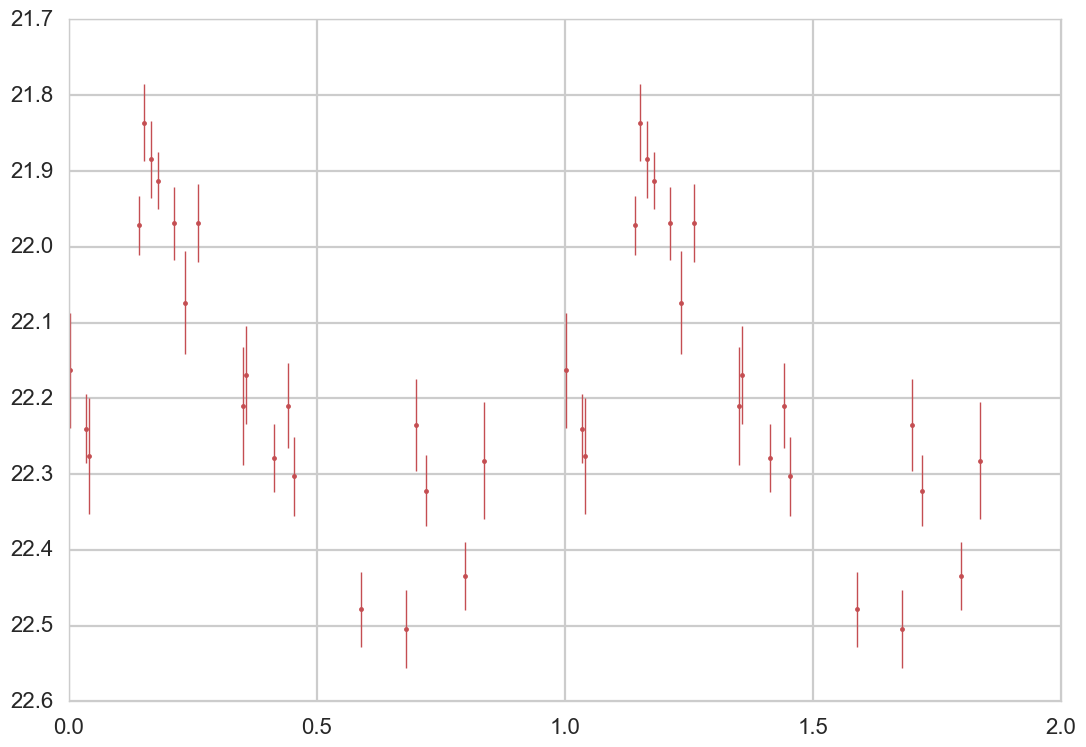

In [12]:
print hits_time.shape

phase = np.mod(hits_time, T) / T
sort_idx = np.argsort(phase)

hits_PHASE = phase[sort_idx]
hits_MAG = hits_mag[sort_idx]
hits_noise_MAG = hits_noise_mag[sort_idx]
hits_ERR = hits_err[sort_idx]

hits_MAG = np.concatenate([hits_MAG,hits_MAG])
hits_noise_MAG = np.concatenate([hits_noise_MAG,hits_noise_MAG])
hits_PHASE = np.concatenate([hits_PHASE,hits_PHASE+1])
hits_ERR = np.concatenate([hits_ERR,hits_ERR])

#plt.errorbar(hits_PHASE, hits_MAG, yerr=hits_ERR, fmt='k.', ms=7, lw=1,alpha=1)
plt.errorbar(hits_PHASE, hits_noise_MAG, yerr=hits_ERR, fmt='r.', ms=7, lw=1,alpha=1)
plt.gca().invert_yaxis()

In [121]:
all_dsct, all_per = [], []
for k in range(1000):
    T_1 = np.random.uniform(0.02, 0.33)
    print '\r',k, T_1,

    # HiTS sampling function
    #hits_time = time_obs[HiTS_sample_func(time_obs)]
    n = np.random.choice(range(49))
    hits_time = time_all[n][:,1]
    # predicted magnitude for GP
    mag_obs = GP_fit(time, mag, err, T, T_1=T_1, plot=False, x_pred=hits_time)
    # scale to HiTS depth and add empirical uncertainties
    hits_mag, hits_noise_mag, hits_err = HiTS_depth_noise(mag_obs)
    if hits_mag.mean() < 20:
        size = int(len(hits_time)*np.random.uniform(.95,1., size=1))
    elif hits_mag.mean() < 22 and hits_mag.mean() > 20:
        size = int(len(hits_time)*np.random.uniform(.85,1., size=1))
    else:
        size = int(len(hits_time)*np.random.uniform(.75,1., size=1))  
    print hits_mag.mean(), size,
    idx = np.sort(np.random.choice(np.arange(len(hits_time)),
                       size=size, replace=False))
    hits_time = hits_time[idx]
    hits_mag = hits_mag[idx]
    hits_noise_mag = hits_noise_mag[idx]
    hits_err = hits_err[idx]

    df = pd.DataFrame(np.array([hits_time, hits_noise_mag, hits_err]).T,
                      columns=['MJD','MAG_KRON','MAGERR_KRON'])
    path = '%s/synt_lcs/dsct_%i_%.6f.csv' % (mainpath,k,T_1)
    df.to_csv(path)
    all_dsct.append(df)
    all_per.append(T_1)

999 0.184016263839 22.539770002 20


## FATS features

In [122]:
import FATS
import P4J
from gatspy.periodic import LombScargle

In [123]:
def calculate_FATS_features(id_lc, lc_g, verbose=True):

    time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                       np.array(lc_g['MAGERR_KRON'].values)
    lc = np.array([mag, time, error])

    if verbose: print 'N Epochs? %i' % len(lc[0])
    # Available imput data
    fats = FATS.FeatureSpace(Data = ['magnitude','time', 'error'],
                                excludeList = ['StetsonJ', 'StetsonL', 'Eta_color', 'Q31_color', 'Color'])
    feat = fats.calculateFeature(lc)
    result = feat.result(method = 'dict')
    result_df = pd.DataFrame.from_dict(result, orient = 'index')
    result_df.columns = [id_lc]
    return result_df.T

def P4J_period(lc_g):

    try:
        time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                           np.array(lc_g['MAGERR_KRON'].values)

        WMCC_model = P4J.periodogram(M=1, method='WMCC')
        WMCC_model.fit(time, mag-np.mean(mag), error)

        per_f = np.max(time) - np.min(time)
        freq, obj = WMCC_model.grid_search(fmin=1/30., fmax=1/.01, fres_coarse=2, fres_fine=0.05, n_local_max=10)
        fbest = WMCC_model.get_best_frequency()
        WMCC_model.fit_extreme_cdf(n_bootstrap=40, n_frequencies=40)
        confidence_best_freq = WMCC_model.get_confidence(fbest[1])
        return 1./fbest[0], confidence_best_freq
    except:
        print 'P4J fail calculating period...'
        return None, None

def gatspy_period(lc_g):

    time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                       np.array(lc_g['MAGERR_KRON'].values)

    per_f = (np.max(time) - np.min(time))*10
    periods = np.linspace(.01, per_f, 10000)

    model = LombScargle(fit_offset=True).fit(time, mag, error)
    power = model.score(periods)

    best_per = periods[np.argmax(power)]

    return best_per

def preprocess_lc(lc, min_mag=15.):
    #time, mag, error = np.array(lc_g['MJD'].quantity), np.array(lc_g['MAG_KRON'].quantity),\
    #                   np.array(lc_g['MAGERR_KRON'].quantity)
    # remove saturated points
    #print 'Original size: %i |' % len(lc),
    lc = lc[lc['MAG_KRON'].values >= min_mag]

    # sigma clipping
    filtered_data = sigma_clip(np.array(lc['MAG_KRON'].values), sigma=4, iters=1, cenfunc=np.mean, copy=False)
    lc = lc[~filtered_data.mask]
    #print ' clipped: %i |' % np.sum(filtered_data.mask),
    #print 'Final size: %i' % len(lc)

    return lc

def get_features(data):
    per = data[0]
    lc = data[1]
    k = data[2]
    lc = preprocess_lc(lc)
    id_lc = 'dsct_%.6f' % (per)
    print '\r LC %i: %s...' % (k,id_lc)
    featur = calculate_FATS_features(id_lc, lc, verbose=False)
    if True:
        period, conf = P4J_period(lc)
        featur['PeriodWMCC'] = period
        featur['PeriodWMCC_conf'] = conf

    if True:
        period = gatspy_period(lc)
        featur['PeriodGLS'] = period
    featur['Real_Period'] = per
    return featur

In [124]:
print len(all_dsct), len(all_per)

1000 1000


In [125]:
from multiprocessing import Pool

In [126]:
p = Pool(processes=3)
frames = p.map(get_features, zip(all_per, all_dsct, range(len(all_per))))

 LC 0: dsct_0.092838...
 LC 84: dsct_0.163609...
 LC 168: dsct_0.191805...
CAR lik se fue a inf
 LC 85: dsct_0.239716...
 LC 1: dsct_0.051636...
 LC 169: dsct_0.133954...
 LC 86: dsct_0.101901...
 LC 2: dsct_0.038047...
 LC 170: dsct_0.320348...
 LC 87: dsct_0.220981...
 LC 3: dsct_0.176753...
 LC 171: dsct_0.198670...
 LC 172: dsct_0.216439...
 LC 88: dsct_0.223208...
 LC 4: dsct_0.067233...
 LC 173: dsct_0.138729...
 LC 89: dsct_0.102711...
 LC 5: dsct_0.167855...
 LC 174: dsct_0.299436...
 LC 6: dsct_0.302549...
 LC 90: dsct_0.238132...
 LC 175: dsct_0.251563...
 LC 7: dsct_0.053215...
 LC 91: dsct_0.195433...
 LC 176: dsct_0.325803...
 LC 8: dsct_0.042002...
 LC 92: dsct_0.175917...
 LC 9: dsct_0.045367...
 LC 177: dsct_0.319741...
 LC 93: dsct_0.145498...
 LC 10: dsct_0.083356...
 LC 178: dsct_0.216777...
 LC 94: dsct_0.244219...
 LC 11: dsct_0.238884...
 LC 179: dsct_0.092530...
 LC 95: dsct_0.301350...
 LC 12: dsct_0.063331...
 LC 180: dsct_0.140901...
 LC 96: dsct_0.302459...
 

In [127]:
fats_feat = pd.concat(frames, axis = 0)
fats_feat = fats_feat[np.sort(fats_feat.columns.values)]
fats_feat['Var_Type'] = 'DSCT'
fats_feat[['Real_Period','Var_Type']].tail()

,Real_Period,Var_Type
dsct_0.127783,0.127783,DSCT
dsct_0.034736,0.034736,DSCT
dsct_0.239408,0.239408,DSCT
dsct_0.042708,0.042708,DSCT
dsct_0.184016,0.184016,DSCT


In [132]:
fats_feat.to_csv('%s/tables/Syntectic_DSCT_features_noise.csv' % (mainpath))

In [129]:
fats_feat_good = fats_feat.query('Period_fit < .5')

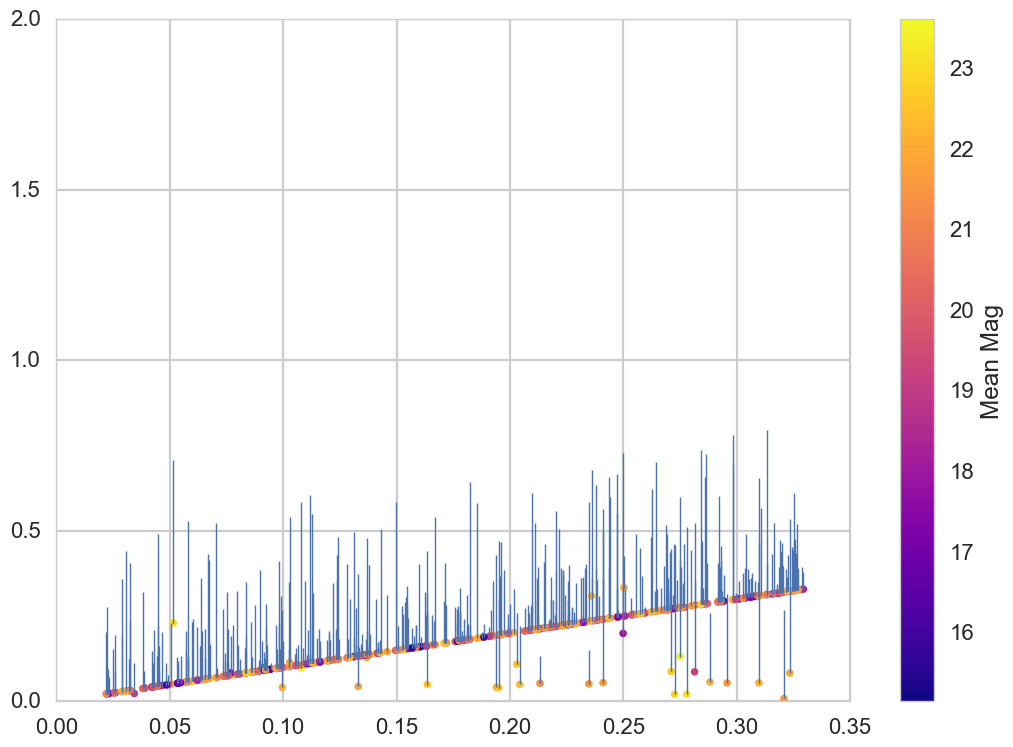

In [130]:
plt.figure()
plt.errorbar(fats_feat_good.Real_Period.values, fats_feat_good.PeriodLS.values,
             yerr=[fats_feat_good.Period_fit.values*0. , fats_feat_good.Period_fit.values],ms=1, fmt='.', lw=1)
plt.scatter(fats_feat_good.Real_Period.values, fats_feat_good.PeriodLS.values,
                c=fats_feat_good.Mean.values, linewidth=0, s=30, alpha=1.,
                cmap=plt.cm.plasma, label='unlabeled')
plt.colorbar(label='Mean Mag')
plt.ylim(0,2)
plt.show()

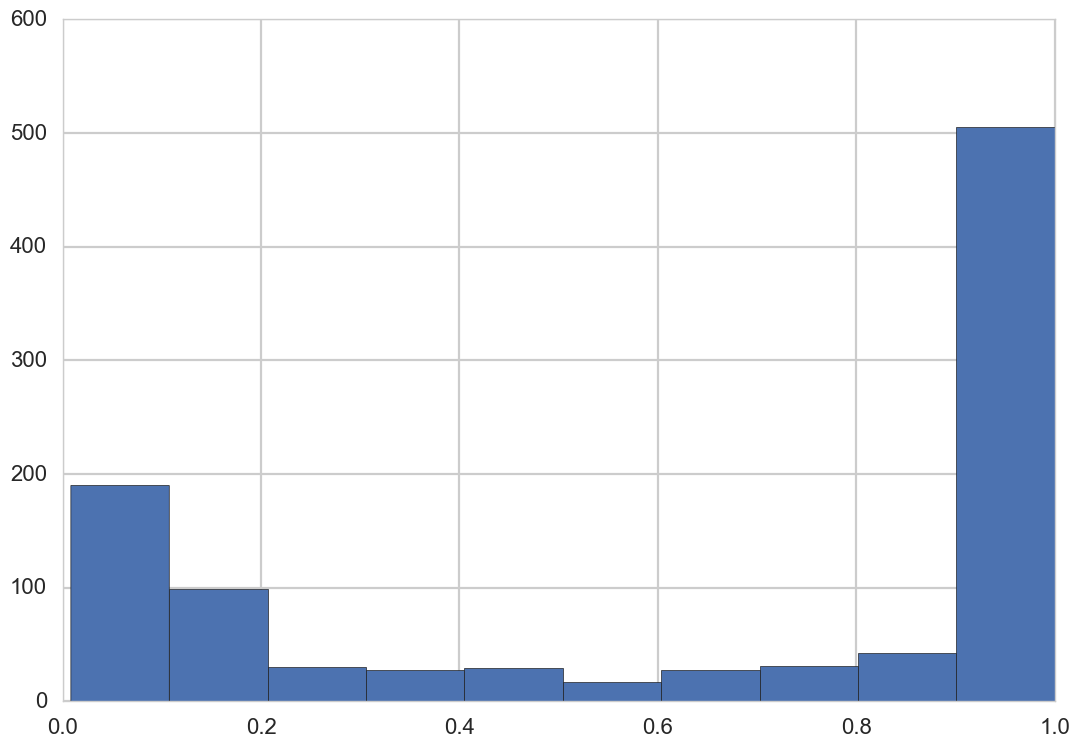

In [131]:
plt.hist(fats_feat.Period_fit.values)
plt.show()